In [1]:
%cd ../..

/home/dmoreno/ATAT_ZTF/elasticc_one


# Confusion matrices

In [2]:
import os
import json 
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

/home/dmoreno/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [21]:
path_data = './data/datasets/ZTF_ff/final/LC_MD_FEAT_v3_fixed_windows_200'
path_results = './results/ZTF_ff/LC/lc_mta_v3_fixed_windows_200_tAPE/MTA'
time_to_eval = 2048

order_classes = ['SNIa', # yes
                 'SNIbc', # yes
                 'SNIIb', # yes
                 'SNII', # yes
                 'SNIIn', # yes
                 'SLSN', # yes
                 'TDE', # yes
                 'Microlensing', # yes
                 'QSO', 
                 'AGN', # yes
                 'Blazar', 
                 'YSO', 
                 'CV/Nova', 
                 'LPV', 
                 'EA', 
                 'EB/EW', # yes
                 'Periodic-Other', 
                 'RSCVn', 
                 'CEP', 
                 'RRLab', 
                 'RRLc', 
                 'DSCT']

In [22]:
code_dict = {
        0: "SNIa",
        1: "SNIbc",
        2: "SNIIb",
        3: "SNII",
        4: "SNIIn",
        5: "SLSN",
        6: "TDE",
        7: "Microlensing",
        8: "QSO",
        9: "AGN",
        10: "Blazar",
        11: "YSO",
        12: "CV/Nova",
        13: "LPV",
        14: "EA",
        15: "EB/EW",
        16: "Periodic-Other",
        17: "RSCVn",
        18: "CEP",
        19: "RRLab",
        20: "RRLc",
        21: "DSCT",
    }

code_dict_a = {
        0: "Transient",
        1: "Transient",
        2: "Transient",
        3: "Transient",
        4: "Transient",
        5: "Transient",
        6: "Transient",
        7: "Transient",
        8: "Stochastic",
        9: "Stochastic",
        10: "Stochastic",
        11: "Stochastic",
        12: "Stochastic",
        13: "Periodic",
        14: "Periodic",
        15: "Periodic",
        16: "Periodic",
        17: "Periodic",
        18: "Periodic",
        19: "Periodic",
        20: "Periodic",
        21: "Periodic",
    }

In [23]:
objects_partitions = pd.read_parquet('./data/datasets/ZTF_ff/partitions/v3/partitions.parquet')
obj_label = objects_partitions[objects_partitions['partition'] == 'test']
y_real_test = obj_label['alerceclass'].values
obj_label = ['aid_{}'.format(x) for x in obj_label['oid'].values]
obj_label

['aid_ZTF18adldhip',
 'aid_ZTF19aasbgeb',
 'aid_ZTF18aayfbqd',
 'aid_ZTF19ablyzbl',
 'aid_ZTF18actabfv',
 'aid_ZTF18aaztkvq',
 'aid_ZTF21aaphzsw',
 'aid_ZTF19aarhrcv',
 'aid_ZTF17aaajmxw',
 'aid_ZTF18acrvact',
 'aid_ZTF22aaahdyl',
 'aid_ZTF18aacebav',
 'aid_ZTF19abnqhwd',
 'aid_ZTF19abjgdow',
 'aid_ZTF18abklljv',
 'aid_ZTF18aalaphh',
 'aid_ZTF23aaaziou',
 'aid_ZTF17aacihzd',
 'aid_ZTF22abnmzar',
 'aid_ZTF17aaaoite',
 'aid_ZTF18abcurfb',
 'aid_ZTF18adbbyzu',
 'aid_ZTF18aaxpqts',
 'aid_ZTF18aacgwxk',
 'aid_ZTF18admcecv',
 'aid_ZTF18abukrnx',
 'aid_ZTF19aapuibt',
 'aid_ZTF18aawccep',
 'aid_ZTF21aahfpup',
 'aid_ZTF19aaoztzf',
 'aid_ZTF18aayijfg',
 'aid_ZTF18abgpcbj',
 'aid_ZTF18abwbiev',
 'aid_ZTF18actawil',
 'aid_ZTF20abyzomt',
 'aid_ZTF17aabxqbf',
 'aid_ZTF18abukymf',
 'aid_ZTF18abvbsoc',
 'aid_ZTF18actunfi',
 'aid_ZTF18aazfeau',
 'aid_ZTF22aaayewi',
 'aid_ZTF18aaxtcdl',
 'aid_ZTF18abtoxjw',
 'aid_ZTF18acdpxfb',
 'aid_ZTF18aabvmax',
 'aid_ZTF18abbogne',
 'aid_ZTF18aapnlus',
 'aid_ZTF18ab

In [24]:
y_real_test.shape

(8346,)

In [25]:
len(obj_label)

8346

In [26]:
import yaml

def load_yaml(path):
    with open(path, 'r') as file:
        args = yaml.load(file, Loader=yaml.FullLoader)
    return args

dict_info = load_yaml('{}/dict_info.yaml'.format(path_data))

mapping_classes = dict_info['mapping_classes']
mapping_classes_inverted = {v: k for k, v in mapping_classes.items()}
print(mapping_classes_inverted)

{0: 'AGN', 8: 'Blazar', 12: 'CEP', 5: 'CV/Nova', 15: 'DSCT', 2: 'EA', 10: 'EB/EW', 11: 'LPV', 21: 'Microlensing', 14: 'Periodic-Other', 1: 'QSO', 13: 'RRLab', 6: 'RRLc', 7: 'RSCVn', 17: 'SLSN', 9: 'SNII', 19: 'SNIIb', 20: 'SNIIn', 4: 'SNIa', 16: 'SNIbc', 18: 'TDE', 3: 'YSO'}


In [27]:
def sort_dict_by_value(d, reverse=False):
    return dict(sorted(d.items(), key=lambda x: x[1], reverse=reverse))

sort_classes = list(sort_dict_by_value(mapping_classes).keys())
print(sort_classes)

['AGN', 'QSO', 'EA', 'YSO', 'SNIa', 'CV/Nova', 'RRLc', 'RSCVn', 'Blazar', 'SNII', 'EB/EW', 'LPV', 'CEP', 'RRLab', 'Periodic-Other', 'DSCT', 'SNIbc', 'SLSN', 'TDE', 'SNIIb', 'SNIIn', 'Microlensing']


In [28]:
combined_dict = {}
for key, class_name in mapping_classes_inverted.items():
    # Buscar el código en code_dict
    for code, name in code_dict.items():
        if name == class_name:
            # Obtener el tipo de code_dict_a
            type_name = code_dict_a[code]
            # Agregar al nuevo diccionario con el nombre como llave
            combined_dict[class_name] = type_name
            break

combined_dict

{'AGN': 'Stochastic',
 'Blazar': 'Stochastic',
 'CEP': 'Periodic',
 'CV/Nova': 'Stochastic',
 'DSCT': 'Periodic',
 'EA': 'Periodic',
 'EB/EW': 'Periodic',
 'LPV': 'Periodic',
 'Microlensing': 'Transient',
 'Periodic-Other': 'Periodic',
 'QSO': 'Stochastic',
 'RRLab': 'Periodic',
 'RRLc': 'Periodic',
 'RSCVn': 'Periodic',
 'SLSN': 'Transient',
 'SNII': 'Transient',
 'SNIIb': 'Transient',
 'SNIIn': 'Transient',
 'SNIa': 'Transient',
 'SNIbc': 'Transient',
 'TDE': 'Transient',
 'YSO': 'Stochastic'}

In [29]:
predictions = torch.load('{}/all_predictions_times.pt'.format(path_results))
predictions

{'SNID': array([b'ZTF17aaaecgi_0', b'ZTF17aaaecgi_1', b'ZTF17aaaecgi_2', ...,
        b'ZTF23abcvqkd_3', b'ZTF23abcvqkd_4', b'ZTF23abcvqkd_5'],
       dtype=object),
 'y_test': tensor([10, 10, 10,  ...,  4,  4,  4]),
 'list_y_pred': {'test_16': array([10, 10, 12, ...,  4,  4,  9]),
  'test_32': array([10, 10, 10, ...,  9,  5,  5]),
  'test_64': array([10, 10, 10, ..., 16,  5,  4]),
  'test_128': array([10, 10, 10, ..., 16,  4,  4]),
  'test_256': array([10, 10, 10, ..., 16,  4,  4]),
  'test_512': array([10, 10, 10, ..., 16,  4,  4]),
  'test_1024': array([10, 10, 10, ..., 16,  4,  4]),
  'test_2048': array([10, 10, 10, ..., 16,  4,  4])},
 'list_y_pred_prob': {'test_16': array([[2.23134572e-04, 4.07648258e-05, 2.93165058e-01, ...,
          2.01592485e-08, 1.93643427e-06, 3.17347792e-09],
         [5.36992520e-05, 1.80695815e-06, 1.29995331e-01, ...,
          1.67156298e-08, 6.33885300e-09, 3.31625394e-10],
         [7.66908779e-05, 3.81138534e-06, 2.14669444e-02, ...,
          2.76

In [30]:
# Procesamiento para agregar los índices correspondientes
from itertools import groupby

# Convertir bytes a str para facilitar la manipulación
snids_str = [snid.decode("utf-8") for snid in predictions['SNID']]

# Función para extraer el identificador base de cada SNID
def base_id(snid):
    return "_".join(snid.split("_")[:-1])

# Agrupar por el identificador base
grouped = groupby(range(len(snids_str)), key=lambda x: base_id(snids_str[x]))

# Crear la nueva clave con los índices agrupados
idx_windows_objects = [list(group) for _, group in grouped]

# Crear la clave 'idx_unique_y_test' con los índices del SNID 0 de todos los objetos
idx_unique_y_test = []
ids_unique_real = []

for i, snid in enumerate(snids_str):
    if snid.endswith("_0"):
        idx_unique_y_test.append(i)
        ids_unique_real.append('aid_{}'.format(snid.split('_')[0]))

# Mostrar el resultado
print('length: ', len(idx_windows_objects))
print('length: ', len(idx_unique_y_test))

length:  41728
length:  41728


In [31]:
print(ids_unique_real)
print(len(ids_unique_real))

['aid_ZTF17aaaecgi', 'aid_ZTF17aaaedvi', 'aid_ZTF17aaafglk', 'aid_ZTF17aaafiut', 'aid_ZTF17aaafiww', 'aid_ZTF17aaafyis', 'aid_ZTF17aaafyxs', 'aid_ZTF17aaagryq', 'aid_ZTF17aaaidzt', 'aid_ZTF17aaaizfv', 'aid_ZTF17aaakbvl', 'aid_ZTF17aaaorgv', 'aid_ZTF17aaaowhs', 'aid_ZTF17aaaqtul', 'aid_ZTF17aaarxab', 'aid_ZTF17aaarxbz', 'aid_ZTF17aaarzye', 'aid_ZTF17aaasboc', 'aid_ZTF17aaasklh', 'aid_ZTF17aaatgma', 'aid_ZTF17aaatkxt', 'aid_ZTF17aaatlhi', 'aid_ZTF17aaauijj', 'aid_ZTF17aaaweng', 'aid_ZTF17aaawqzp', 'aid_ZTF17aabhlnm', 'aid_ZTF17aabooqt', 'aid_ZTF17aabootn', 'aid_ZTF17aabopzp', 'aid_ZTF17aaboqfs', 'aid_ZTF17aabppsz', 'aid_ZTF17aabppwh', 'aid_ZTF17aabqidu', 'aid_ZTF17aabummz', 'aid_ZTF17aabupde', 'aid_ZTF17aabuphg', 'aid_ZTF17aabuuyx', 'aid_ZTF17aabuvjm', 'aid_ZTF17aabvgfc', 'aid_ZTF17aabviic', 'aid_ZTF17aabxamk', 'aid_ZTF17aabxkhe', 'aid_ZTF17aacgwpq', 'aid_ZTF17aackses', 'aid_ZTF17aactvce', 'aid_ZTF17aadgwyo', 'aid_ZTF17aadidmw', 'aid_ZTF17aadjkhd', 'aid_ZTF17aadooax', 'aid_ZTF18aaaajiw',

In [32]:
# Calcular el promedio de las probabilidades para cada conjunto de ventanas

predictions.update({
    'list_y_pred_prob_avg': dict(),
    'list_y_pred_avg': dict(),
    })

for eval_time, predicciones in predictions['list_y_pred_prob'].items():
    predictions['list_y_pred_prob_avg'][eval_time] = [] 
    predictions['list_y_pred_avg'][eval_time] = [] 
    for idx_windows in idx_windows_objects:
        window_probs = predicciones[idx_windows]
        avg_probs = np.mean(window_probs, axis=0)
        predictions['list_y_pred_prob_avg'][eval_time].append(avg_probs)
        predictions['list_y_pred_avg'][eval_time].append(np.argmax(avg_probs, axis=0))

    predictions['list_y_pred_prob_avg'][eval_time] = np.array(predictions['list_y_pred_prob_avg'][eval_time])
    predictions['list_y_pred_avg'][eval_time] = np.array(predictions['list_y_pred_avg'][eval_time])

predictions['list_y_pred_avg']

{'test_16': array([10, 11, 13, ..., 20,  4,  9]),
 'test_32': array([10, 11,  5, ..., 18,  4,  4]),
 'test_64': array([10, 11,  5, ..., 20,  4,  4]),
 'test_128': array([10, 11,  5, ..., 20,  4,  4]),
 'test_256': array([10, 11,  5, ..., 20,  4,  4]),
 'test_512': array([10, 11,  5, ..., 20,  4,  4]),
 'test_1024': array([10, 11,  5, ..., 20,  4,  4]),
 'test_2048': array([10, 11,  5, ..., 20,  4,  4])}

In [33]:
predictions['list_y_pred_avg']['test_2048'].shape

(41728,)

In [34]:
predictions.keys()

dict_keys(['SNID', 'y_test', 'list_y_pred', 'list_y_pred_prob', 'list_y_pred_prob_avg', 'list_y_pred_avg'])

In [35]:
predictions['y_test'].shape

torch.Size([252810])

In [36]:
predictions['SNID'].shape

(252810,)

In [37]:
print(idx_unique_y_test)

[0, 8, 16, 21, 30, 38, 46, 54, 57, 62, 67, 74, 80, 84, 96, 101, 106, 113, 119, 124, 128, 132, 139, 144, 155, 164, 168, 177, 189, 200, 209, 218, 227, 235, 245, 255, 263, 271, 279, 288, 295, 304, 310, 314, 319, 320, 325, 330, 334, 338, 341, 347, 354, 363, 370, 377, 384, 392, 395, 402, 408, 415, 422, 430, 438, 445, 453, 462, 472, 479, 488, 494, 500, 504, 511, 515, 530, 543, 548, 554, 561, 572, 585, 597, 610, 622, 635, 642, 654, 662, 671, 678, 693, 706, 713, 719, 724, 734, 742, 746, 756, 772, 781, 788, 794, 802, 811, 819, 826, 835, 843, 847, 859, 867, 879, 894, 898, 907, 915, 922, 930, 939, 946, 953, 961, 970, 979, 988, 997, 1009, 1012, 1019, 1031, 1040, 1051, 1059, 1066, 1074, 1081, 1090, 1097, 1101, 1109, 1117, 1128, 1133, 1140, 1152, 1163, 1170, 1181, 1184, 1192, 1199, 1207, 1211, 1221, 1234, 1241, 1251, 1260, 1267, 1277, 1281, 1289, 1295, 1304, 1310, 1318, 1324, 1328, 1332, 1338, 1350, 1356, 1361, 1368, 1375, 1384, 1392, 1398, 1405, 1413, 1418, 1426, 1434, 1446, 1453, 1459, 1465, 1473,

In [38]:
print(ids_unique_real)

['aid_ZTF17aaaecgi', 'aid_ZTF17aaaedvi', 'aid_ZTF17aaafglk', 'aid_ZTF17aaafiut', 'aid_ZTF17aaafiww', 'aid_ZTF17aaafyis', 'aid_ZTF17aaafyxs', 'aid_ZTF17aaagryq', 'aid_ZTF17aaaidzt', 'aid_ZTF17aaaizfv', 'aid_ZTF17aaakbvl', 'aid_ZTF17aaaorgv', 'aid_ZTF17aaaowhs', 'aid_ZTF17aaaqtul', 'aid_ZTF17aaarxab', 'aid_ZTF17aaarxbz', 'aid_ZTF17aaarzye', 'aid_ZTF17aaasboc', 'aid_ZTF17aaasklh', 'aid_ZTF17aaatgma', 'aid_ZTF17aaatkxt', 'aid_ZTF17aaatlhi', 'aid_ZTF17aaauijj', 'aid_ZTF17aaaweng', 'aid_ZTF17aaawqzp', 'aid_ZTF17aabhlnm', 'aid_ZTF17aabooqt', 'aid_ZTF17aabootn', 'aid_ZTF17aabopzp', 'aid_ZTF17aaboqfs', 'aid_ZTF17aabppsz', 'aid_ZTF17aabppwh', 'aid_ZTF17aabqidu', 'aid_ZTF17aabummz', 'aid_ZTF17aabupde', 'aid_ZTF17aabuphg', 'aid_ZTF17aabuuyx', 'aid_ZTF17aabuvjm', 'aid_ZTF17aabvgfc', 'aid_ZTF17aabviic', 'aid_ZTF17aabxamk', 'aid_ZTF17aabxkhe', 'aid_ZTF17aacgwpq', 'aid_ZTF17aackses', 'aid_ZTF17aactvce', 'aid_ZTF17aadgwyo', 'aid_ZTF17aadidmw', 'aid_ZTF17aadjkhd', 'aid_ZTF17aadooax', 'aid_ZTF18aaaajiw',

In [39]:
predictions['labels_final'] = predictions['y_test'][idx_unique_y_test]
predictions['ids_final'] = np.array(ids_unique_real)
print(predictions['labels_final'].shape)

df_atat_pred = []

for eval_time, prob_classes in predictions['list_y_pred_prob_avg'].items():
    df = pd.DataFrame(prob_classes, columns=sort_classes)
    df['shorten'] = str(eval_time.split('_')[-1])
    df.index = predictions['ids_final']
    df_atat_pred.append(df)

df_atat_pred = pd.concat(df_atat_pred)
df_atat_pred

torch.Size([41728])


AGN           QSO            EA           YSO   
aid_ZTF17aaaecgi  1.535725e-04  1.983006e-05  8.299133e-02  9.266480e-03  \
aid_ZTF17aaaedvi  3.559729e-04  6.540951e-05  2.802121e-03  1.698939e-02   
aid_ZTF17aaafglk  3.116087e-02  3.269039e-02  2.916128e-02  8.043333e-02   
aid_ZTF17aaafiut  3.790900e-03  2.205182e-04  4.684974e-01  6.738487e-02   
aid_ZTF17aaafiww  7.359702e-04  1.271521e-04  1.307263e-01  3.296248e-02   
...                        ...           ...           ...           ...   
aid_ZTF23aamapva  5.926995e-03  1.138667e-03  2.861305e-04  5.192338e-04   
aid_ZTF23aamsarj  4.158906e-04  6.284639e-04  7.664263e-04  1.691192e-03   
aid_ZTF23aamxeoe  1.422995e-07  1.016881e-07  2.481042e-09  1.057757e-10   
aid_ZTF23aavxvsz  1.378378e-02  1.236731e-02  4.619008e-03  2.195038e-02   
aid_ZTF23abcvqkd  4.934477e-04  9.946487e-04  1.511350e-03  5.685686e-03   

                          SNIa       CV/Nova          RRLc         RSCVn   
aid_ZTF17aaaecgi  3.885808e-05  4.175568e-03  2.950037e-02  3.992287e-02  \
aid_ZTF17aaaedvi  5.218536e-04  6.939776e-03  1.077003e-04  5.763343e-03   
aid_ZTF17aaafglk  9.486125e-03  6.027072e-02  1.016092e-01  8.464622e-02   
aid_ZTF17aaafiut  1.016888e-03  4.774333e-03  2.241201e-03  1.617332e-01   
aid_ZTF17aaafiww  1.198167e-04  8.285610e-03  7.175803e-02  9.417112e-02   
...                        ...           ...           ...           ...   
aid_ZTF23aamapva  1.465379e-04  2.431854e-03  3.350487e-03  3.142509e-03   
aid_ZTF23aamsarj  2.437132e-01  2.428589e-02  1.198972e-06  2.249405e-05   
aid_ZTF23aamxeoe  4.722529e-08  4.601883e-08  9.700193e-11  2.887950e-10   
aid_ZTF23aavxvsz  6.601430e-01  1.924549e-01  1.273555e-04  5.693455e-04   
aid_ZTF23abcvqkd  4.390880e-01  4.370807e-02  2.278511e-06  6.128540e-06   

                        Blazar          SNII  ...         RRLab   
aid_ZTF17aaaecgi  2.261072e-04  1.004515e-05  ...  7.956896e-03  \
aid_ZTF17aaaedvi  2.313943e-04  4.453330e-04  ...  6.203923e-04   
aid_ZTF17aaafglk  2.220623e-02  1.245694e-02  ...  1.316770e-01   
aid_ZTF17aaafiut  1.387036e-03  4.280061e-03  ...  1.589834e-03   
aid_ZTF17aaafiww  1.561138e-03  2.731590e-05  ...  5.061927e-02   
...                        ...           ...  ...           ...   
aid_ZTF23aamapva  2.761050e-03  1.458426e-04  ...  3.531324e-04   
aid_ZTF23aamsarj  5.871388e-05  3.946279e-01  ...  2.640927e-05   
aid_ZTF23aamxeoe  1.486021e-08  3.648308e-07  ...  2.261251e-10   
aid_ZTF23aavxvsz  4.013661e-02  3.271651e-02  ...  3.580335e-03   
aid_ZTF23abcvqkd  6.573970e-04  3.641043e-01  ...  2.472438e-05   

                  Periodic-Other          DSCT         SNIbc          SLSN   
aid_ZTF17aaaecgi    3.018332e-02  2.275388e-02  1.914303e-07  1.115882e-08  \
aid_ZTF17aaaedvi    2.589546e-03  2.774287e-04  4.530651e-05  1.388144e-09   
aid_ZTF17aaafglk    6.494047e-02  1.112081e-01  1.321903e-03  8.317447e-03   
aid_ZTF17aaafiut    6.588069e-03  4.892061e-03  3.280972e-03  9.717504e-09   
aid_ZTF17aaafiww    9.397572e-02  9.410023e-02  9.905211e-07  1.755814e-06   
...                          ...           ...           ...           ...   
aid_ZTF23aamapva    9.660597e-01  3.238945e-03  1.008907e-07  9.426755e-10   
aid_ZTF23aamsarj    1.914376e-08  7.192771e-07  3.356750e-03  1.441587e-07   
aid_ZTF23aamxeoe    6.556776e-10  2.953920e-11  4.352158e-12  5.835187e-18   
aid_ZTF23aavxvsz    1.629154e-05  2.927904e-05  1.982108e-05  1.702354e-05   
aid_ZTF23abcvqkd    4.880390e-08  3.116323e-06  1.429273e-01  1.741148e-05   

                           TDE         SNIIb         SNIIn  Microlensing   
aid_ZTF17aaaecgi  9.690539e-10  2.822947e-08  3.324804e-07  1.102095e-09  \
aid_ZTF17aaaedvi  1.314958e-11  7.764422e-11  2.852552e-06  1.911863e-10   
aid_ZTF17aaafglk  8.668782e-03  1.916950e-04  2.063390e-03  2.950261e-04   
aid_ZTF17aaafiut  1.341543e-11  7.764241e-05  6.757416e-03  1.521313e-10   
aid_ZTF17aaafiww  5.659646e-09  4.814412e-08  1.368372e-06  8.147978e-08   
...

In [40]:
atat_pred_2048_time_test = df_atat_pred[df_atat_pred['shorten'] == '2048']
atat_pred_2048_time_test = atat_pred_2048_time_test.reindex(obj_label)[sort_classes]
atat_pred_2048_time_test

AGN       QSO        EA       YSO      SNIa   CV/Nova   
aid_ZTF18adldhip  0.382684  0.299601  0.029838  0.000579  0.004080  0.073453  \
aid_ZTF19aasbgeb  0.220042  0.636075  0.000005  0.000037  0.038798  0.002306   
aid_ZTF18aayfbqd  0.000186  0.000119  0.661490  0.133736  0.000005  0.000270   
aid_ZTF19ablyzbl  0.450831  0.320378  0.000239  0.000076  0.023323  0.006806   
aid_ZTF18actabfv  0.004436  0.000634  0.015364  0.700969  0.007425  0.005314   
...                    ...       ...       ...       ...       ...       ...   
aid_ZTF18abdlmwe  0.000077  0.000011  0.018881  0.122300  0.000003  0.000808   
aid_ZTF18abnueof  0.000212  0.000088  0.000041  0.000069  0.000020  0.002109   
aid_ZTF17aaagvih  0.000958  0.000115  0.184460  0.027554  0.001229  0.009049   
aid_ZTF17aabpjme  0.000066  0.000022  0.000321  0.000964  0.000020  0.002759   
aid_ZTF18acrwlnr  0.002095  0.000089  0.002113  0.574942  0.000142  0.018935   

                      RRLc     RSCVn    Blazar          SNII  ...       CEP   
aid_ZTF18adldhip  0.012451  0.007260  0.028162  1.774357e-03  ...  0.003819  \
aid_ZTF19aasbgeb  0.000024  0.000020  0.092206  1.002425e-02  ...  0.000032   
aid_ZTF18aayfbqd  0.000114  0.000646  0.000072  7.319501e-05  ...  0.004396   
aid_ZTF19ablyzbl  0.000090  0.001089  0.134072  3.122778e-03  ...  0.000009   
aid_ZTF18actabfv  0.000150  0.071187  0.004000  7.537382e-04  ...  0.028009   
...                    ...       ...       ...           ...  ...       ...   
aid_ZTF18abdlmwe  0.001595  0.046454  0.000072  1.141977e-06  ...  0.789569   
aid_ZTF18abnueof  0.491010  0.007507  0.000022  5.982954e-06  ...  0.063211   
aid_ZTF17aaagvih  0.002738  0.006629  0.054289  1.253311e-03  ...  0.405690   
aid_ZTF17aabpjme  0.015513  0.021721  0.000805  5.378231e-07  ...  0.062252   
aid_ZTF18acrwlnr  0.000170  0.041597  0.046533  1.126988e-04  ...  0.188471   

                     RRLab  Periodic-Other          DSCT         SNIbc   
aid_ZTF18adldhip  0.001223    9.471153e-02  4.485216e-02  2.449554e-04  \
aid_ZTF19aasbgeb  0.000057    1.150881e-06  7.448483e-07  2.109425e-04   
aid_ZTF18aayfbqd  0.000158    1.036956e-07  1.396379e-04  8.750602e-09   
aid_ZTF19ablyzbl  0.000158    5.307570e-07  7.165972e-05  2.720419e-04   
aid_ZTF18actabfv  0.000230    1.395763e-01  1.923406e-03  1.637022e-05   
...                    ...             ...           ...           ...   
aid_ZTF18abdlmwe  0.002372    6.007887e-05  2.137955e-04  3.615313e-08   
aid_ZTF18abnueof  0.112137    7.082156e-03  3.160432e-01  5.357313e-06   
aid_ZTF17aaagvih  0.034599    1.756510e-03  4.359715e-03  9.735798e-08   
aid_ZTF17aabpjme  0.847659    5.393412e-04  2.777242e-02  7.611754e-06   
aid_ZTF18acrwlnr  0.010735    3.882881e-04  4.135900e-03  1.226320e-06   

                          SLSN           TDE         SNIIb         SNIIn   
aid_ZTF18adldhip  6.545255e-06  1.004791e-02  2.479518e-07  2.010322e-04  \
aid_ZTF19aasbgeb  7.138036e-07  4.245488e-07  3.032216e-08  1.546724e-04   
aid_ZTF18aayfbqd  1.296540e-13  6.074956e-08  1.059477e-10  4.495132e-09   
aid_ZTF19ablyzbl  5.727119e-02  8.215768e-08  8.633140e-06  2.055878e-03   
aid_ZTF18actabfv  4.698527e-09  1.765329e-10  9.480575e-08  1.406504e-07   
...                        ...           ...           ...           ...   
aid_ZTF18abdlmwe  2.632440e-08  4.496217e-08  1.845478e-11  1.672199e-06   
aid_ZTF18abnueof  1.617652e-10  3.481447e-07  1.484366e-07  1.006523e-06   
aid_ZTF17aaagvih  2.840282e-09  5.060167e-12  2.621970e-09  5.748129e-08   
aid_ZTF17aabpjme  3.398853e-08  3.802331e-12  2.700587e-07  1.444441e-08   
aid_ZTF18acrwlnr  1.482403e-09  1.760234e-10  4.110924e-14  1.415763e-05   

                  Microlensing  
aid_ZTF18adldhip  2.055293e-09  
aid_ZTF19aasbgeb  4.885924e-10  
aid_ZTF18aayfbqd  2.031221e-06  
aid_ZTF19ablyzbl  5.692172e-10  
aid_ZTF18actabfv  1.635080e-09  
...                        ...  
aid_ZTF18abdlmwe  1.034002e-11  
aid_ZTF18abnueof  8.332088e-12  
aid_ZTF17aaagv

In [41]:
atat_pred_2048_time_test

AGN       QSO        EA       YSO      SNIa   CV/Nova   
aid_ZTF18adldhip  0.382684  0.299601  0.029838  0.000579  0.004080  0.073453  \
aid_ZTF19aasbgeb  0.220042  0.636075  0.000005  0.000037  0.038798  0.002306   
aid_ZTF18aayfbqd  0.000186  0.000119  0.661490  0.133736  0.000005  0.000270   
aid_ZTF19ablyzbl  0.450831  0.320378  0.000239  0.000076  0.023323  0.006806   
aid_ZTF18actabfv  0.004436  0.000634  0.015364  0.700969  0.007425  0.005314   
...                    ...       ...       ...       ...       ...       ...   
aid_ZTF18abdlmwe  0.000077  0.000011  0.018881  0.122300  0.000003  0.000808   
aid_ZTF18abnueof  0.000212  0.000088  0.000041  0.000069  0.000020  0.002109   
aid_ZTF17aaagvih  0.000958  0.000115  0.184460  0.027554  0.001229  0.009049   
aid_ZTF17aabpjme  0.000066  0.000022  0.000321  0.000964  0.000020  0.002759   
aid_ZTF18acrwlnr  0.002095  0.000089  0.002113  0.574942  0.000142  0.018935   

                      RRLc     RSCVn    Blazar          SNII  ...       CEP   
aid_ZTF18adldhip  0.012451  0.007260  0.028162  1.774357e-03  ...  0.003819  \
aid_ZTF19aasbgeb  0.000024  0.000020  0.092206  1.002425e-02  ...  0.000032   
aid_ZTF18aayfbqd  0.000114  0.000646  0.000072  7.319501e-05  ...  0.004396   
aid_ZTF19ablyzbl  0.000090  0.001089  0.134072  3.122778e-03  ...  0.000009   
aid_ZTF18actabfv  0.000150  0.071187  0.004000  7.537382e-04  ...  0.028009   
...                    ...       ...       ...           ...  ...       ...   
aid_ZTF18abdlmwe  0.001595  0.046454  0.000072  1.141977e-06  ...  0.789569   
aid_ZTF18abnueof  0.491010  0.007507  0.000022  5.982954e-06  ...  0.063211   
aid_ZTF17aaagvih  0.002738  0.006629  0.054289  1.253311e-03  ...  0.405690   
aid_ZTF17aabpjme  0.015513  0.021721  0.000805  5.378231e-07  ...  0.062252   
aid_ZTF18acrwlnr  0.000170  0.041597  0.046533  1.126988e-04  ...  0.188471   

                     RRLab  Periodic-Other          DSCT         SNIbc   
aid_ZTF18adldhip  0.001223    9.471153e-02  4.485216e-02  2.449554e-04  \
aid_ZTF19aasbgeb  0.000057    1.150881e-06  7.448483e-07  2.109425e-04   
aid_ZTF18aayfbqd  0.000158    1.036956e-07  1.396379e-04  8.750602e-09   
aid_ZTF19ablyzbl  0.000158    5.307570e-07  7.165972e-05  2.720419e-04   
aid_ZTF18actabfv  0.000230    1.395763e-01  1.923406e-03  1.637022e-05   
...                    ...             ...           ...           ...   
aid_ZTF18abdlmwe  0.002372    6.007887e-05  2.137955e-04  3.615313e-08   
aid_ZTF18abnueof  0.112137    7.082156e-03  3.160432e-01  5.357313e-06   
aid_ZTF17aaagvih  0.034599    1.756510e-03  4.359715e-03  9.735798e-08   
aid_ZTF17aabpjme  0.847659    5.393412e-04  2.777242e-02  7.611754e-06   
aid_ZTF18acrwlnr  0.010735    3.882881e-04  4.135900e-03  1.226320e-06   

                          SLSN           TDE         SNIIb         SNIIn   
aid_ZTF18adldhip  6.545255e-06  1.004791e-02  2.479518e-07  2.010322e-04  \
aid_ZTF19aasbgeb  7.138036e-07  4.245488e-07  3.032216e-08  1.546724e-04   
aid_ZTF18aayfbqd  1.296540e-13  6.074956e-08  1.059477e-10  4.495132e-09   
aid_ZTF19ablyzbl  5.727119e-02  8.215768e-08  8.633140e-06  2.055878e-03   
aid_ZTF18actabfv  4.698527e-09  1.765329e-10  9.480575e-08  1.406504e-07   
...                        ...           ...           ...           ...   
aid_ZTF18abdlmwe  2.632440e-08  4.496217e-08  1.845478e-11  1.672199e-06   
aid_ZTF18abnueof  1.617652e-10  3.481447e-07  1.484366e-07  1.006523e-06   
aid_ZTF17aaagvih  2.840282e-09  5.060167e-12  2.621970e-09  5.748129e-08   
aid_ZTF17aabpjme  3.398853e-08  3.802331e-12  2.700587e-07  1.444441e-08   
aid_ZTF18acrwlnr  1.482403e-09  1.760234e-10  4.110924e-14  1.415763e-05   

                  Microlensing  
aid_ZTF18adldhip  2.055293e-09  
aid_ZTF19aasbgeb  4.885924e-10  
aid_ZTF18aayfbqd  2.031221e-06  
aid_ZTF19ablyzbl  5.692172e-10  
aid_ZTF18actabfv  1.635080e-09  
...                        ...  
aid_ZTF18abdlmwe  1.034002e-11  
aid_ZTF18abnueof  8.332088e-12  
aid_ZTF17aaagv

In [42]:
y_pred_test = atat_pred_2048_time_test.idxmax(axis=1).values
y_pred_test

array(['AGN', 'QSO', 'EA', ..., 'CEP', 'RRLab', 'YSO'], dtype=object)

In [43]:
y_real_test

array(['AGN', 'QSO', 'EA', ..., 'YSO', 'RRLab', 'YSO'], dtype=object)

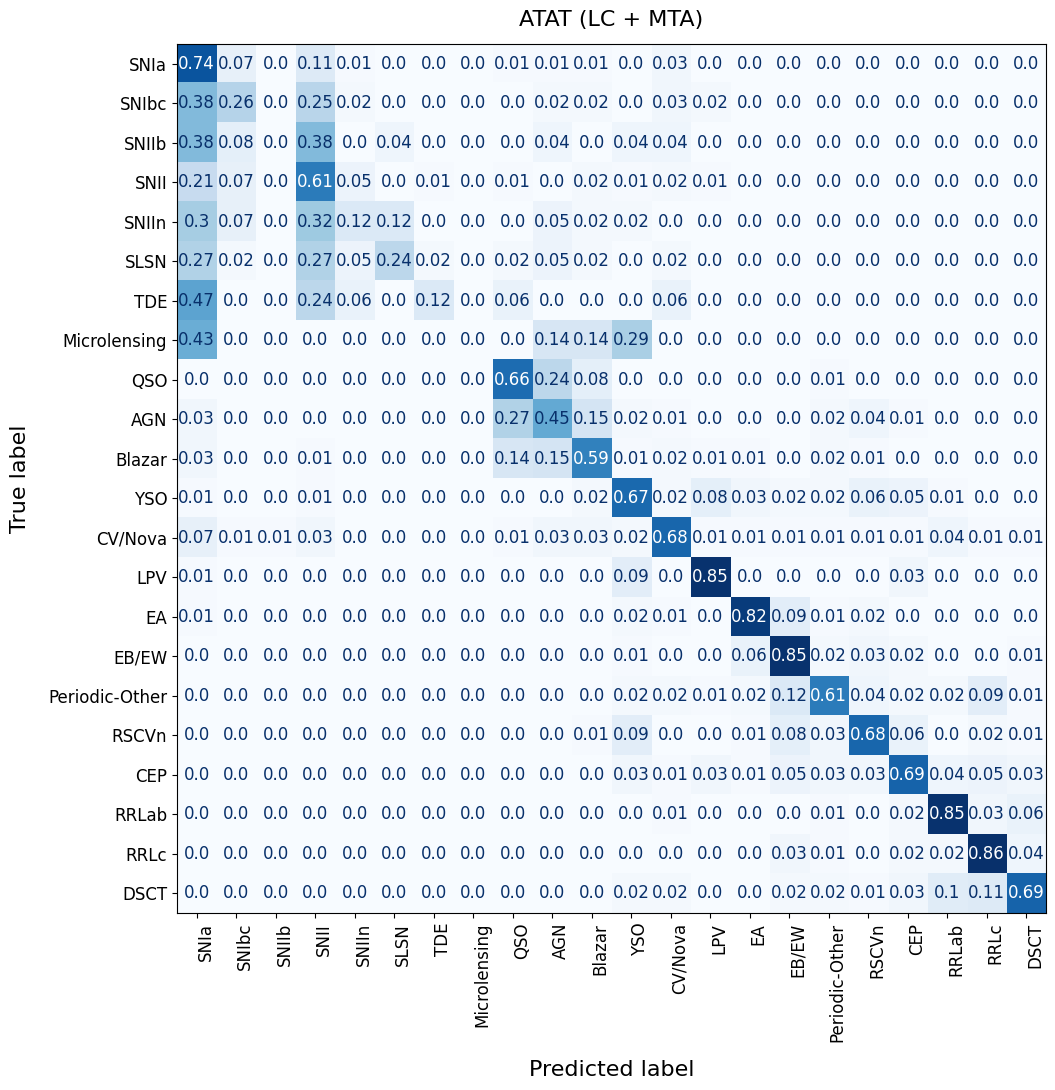

In [44]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

fs = 12

cm = confusion_matrix(y_true=y_real_test, y_pred=y_pred_test, labels=order_classes, normalize='true')

cmap = plt.cm.Blues
fig, ax = plt.subplots(figsize=(11, 11)) #, dpi=110)
im = ax.imshow(np.around(cm, decimals=2), interpolation='nearest', cmap=cmap)

# color map
new_color = cmap(1.0) 

# Añadiendo manualmente las anotaciones con la media y desviación estándar
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] >= 0.005:
            #print(cm[i, j])
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)
        else:
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)

# Ajustes finales y mostrar la gráfica
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(np.arange(len(order_classes)))
ax.set_yticks(np.arange(len(order_classes)))
ax.set_xticklabels(order_classes)
ax.set_yticklabels(order_classes)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

ax.set_title('ATAT (LC + MTA)', fontsize=16, pad=13)
ax.set_xlabel('Predicted label', fontsize=16, labelpad=13)  # Label del eje x
ax.set_ylabel('True label', fontsize=16, labelpad=13)        # Label del eje y

ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.xaxis.labelpad = 13
ax.yaxis.labelpad = 13

plt.tight_layout()
plt.show()

In [45]:
from sklearn.metrics import f1_score

f1_score(y_real_test, y_pred_test, average='macro')

0.5493198567728507